# Capstone II: Keras model

In [1]:
# import the packages
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from tqdm import tqdm
import pandas as pd
import shutil
from keras.preprocessing.image import array_to_img, img_to_array
from glob import glob
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix
import itertools

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [35]:
# set up the keras pre-processing and data batch generators to prep the data for the network

from keras.preprocessing.image import ImageDataGenerator

batch_size = 128

# this is the data generator that will preprocess and augment the image data prior to analysis
train_datagen = ImageDataGenerator(rotation_range=10,            # degree of rotation in the image
                             width_shift_range=0.1,              # widthwise shift of the image
                             height_shift_range=0.1,             # heightwise shift of the image
                             shear_range=0.1,                    # random shear percentage
                             zoom_range=0.1,                     # image zoom range
                             horizontal_flip=False,              # horzontal-flip?
                             fill_mode='nearest')                


# training data generator
train_generator = train_datagen.flow_from_directory('train/',  # this is the target directory
                                                    target_size=(224, 224),  # all images will be resized to 150x150
                                                    batch_size=batch_size,
                                                    class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# validation generator
validation_generator = train_datagen.flow_from_directory('validation/',
                                                        target_size=(224, 224),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

# testing generator
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory('test/',
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


Found 71359 images belonging to 9 classes.
Found 15292 images belonging to 9 classes.
Found 15296 images belonging to 9 classes.


In [93]:
path_list = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Effusion', 'Infiltration', 
                 'Mass', 'No Finding', 'Pneumothorax', 'No Finding']

In [98]:
validation_generator.class_indices

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Infiltration': 5,
 'Mass': 6,
 'No Finding': 7,
 'Pneumothorax': 8}

In [38]:
# defining the image dimensions
t_x, t_y = next(train_generator)

In [39]:
print('shape x:', t_x.shape[1:])

shape x: (224, 224, 3)


In [40]:
t_y[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

### ResNet 50 Model

In [41]:
# bringing in the resnet50 model
from sklearn.metrics import classification_report

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [52]:
# setting the number of classes
num_classes=9

In [53]:
# set the base_model and lock the layers initially
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=t_x.shape[1:])

for layer in base_model.layers: layer.trainable = False


In [54]:
# add in two dense layers and a softmax final layer for the output, on top of the resnet50 model

model = Sequential()

model.add(base_model)

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(num_classes, activation='sigmoid'))

# Tabular representation of the model defined above, note that all the layers of the resnet50 model are listed as well
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 4617      
Total params: 24,904,073
Trainable params: 1,316,361
Non-trainable params: 23,587,712
_________________________________________________________________


In [55]:
# compine the modelm define the optimizer function, and define the model assessment metrics
model.compile(loss='binary_crossentropy',    #why we use this
              optimizer='rmsprop',                #why we use this
              metrics=['accuracy', 'mae'])               #why we use this

### CallBacks and model evaluation parameters

In [56]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [57]:
# set where, when, and what to save from the model as it progressess through the evaluation
path= '/models'
checkpoint = ModelCheckpoint(path,
                     monitor='val_acc',
                     verbose=1,
                     mode='auto',
                     period=1)

# instantiate and set parameters for to get live and graphical assessment metrics of how the model is performing
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size, write_graph=True, 
                                           write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None,
                                           embeddings_metadata=None)


In [58]:
# set the number of epics and where the model will pull data from
num_epochs=5
train_size=train_generator.n
validation_size=validation_generator.n
test_size=test_generator.n

In [ ]:
#from keras.models import load_model
#model = load_model('first_trans_1.h5')

In [59]:
%%time
# fit the model and tie it to the setting defined above
history_1 = model.fit_generator(train_generator,
                                epochs=num_epochs,
                                steps_per_epoch=(train_size // batch_size) + 1,
                                validation_data=validation_generator,
                                validation_steps=(validation_size // batch_size) + 1,
                                callbacks=[checkpoint, tensorboard])

Epoch 1/5
557/558 [============================>.] - ETA: 3s - loss: 0.2319 - acc: 0.9156 - mean_absolute_error: 0.1294
Epoch 00001: saving model to /models
558/558 [==============================] - 2249s 4s/step - loss: 0.2319 - acc: 0.9156 - mean_absolute_error: 0.1294 - val_loss: 0.3025 - val_acc: 0.9094 - val_mean_absolute_error: 0.1002
Epoch 2/5
557/558 [============================>.] - ETA: 3s - loss: 0.2176 - acc: 0.9200 - mean_absolute_error: 0.1244
Epoch 00002: saving model to /models
558/558 [==============================] - 2303s 4s/step - loss: 0.2176 - acc: 0.9200 - mean_absolute_error: 0.1244 - val_loss: 0.3020 - val_acc: 0.9094 - val_mean_absolute_error: 0.1009
Epoch 3/5
557/558 [============================>.] - ETA: 3s - loss: 0.2152 - acc: 0.9206 - mean_absolute_error: 0.1233
Epoch 00003: saving model to /models
558/558 [==============================] - 2508s 4s/step - loss: 0.2152 - acc: 0.9206 - mean_absolute_error: 0.1233 - val_loss: 0.2959 - val_acc: 0.9104 - 

In [60]:
print(history_1.history.keys())  

dict_keys(['val_loss', 'val_acc', 'val_mean_absolute_error', 'loss', 'acc', 'mean_absolute_error'])


dict_keys(['val_loss', 'val_acc', 'val_mean_absolute_error', 'loss', 'acc', 'mean_absolute_error'])


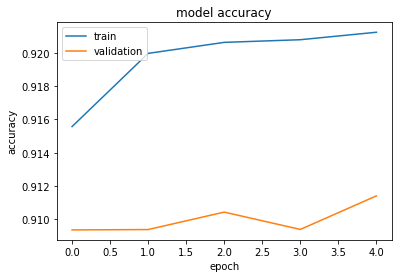

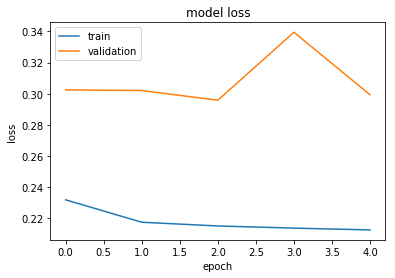

In [61]:
# trace the accuacy and loss across all epochs
print(history_1.history.keys())  

# summarize history for accuracy
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [62]:
# save the model weights to this point in the training
model.save_weights('first_trans_1.h5')  # always save your weights after training or during training

In [63]:
pred_Y_1 = model.predict(t_x, batch_size = 32, verbose = True)

128/128 [==============================] - 1s 11ms/step


In [64]:
y_classes = np.argmax(pred_Y_1, axis=1)
y_classes

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [65]:
y_true = np.argmax(t_y,axis = 1)
y_true

array([7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 8, 7, 8, 7, 7, 7, 7, 7,
       7, 7, 7, 4, 7, 8, 7, 7, 7, 5, 7, 7, 7, 5, 7, 7, 7, 4, 7, 8, 7, 4,
       5, 7, 7, 5, 7, 7, 7, 1, 7, 7, 7, 7, 5, 7, 7, 3, 2, 7, 7, 5, 1, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 5, 5, 7, 5, 2, 7, 7, 7, 7, 6, 8,
       7, 5, 4, 8, 2, 7, 5, 7, 6, 8, 5, 5, 7, 7, 8, 7, 4, 7, 7, 7, 5, 7,
       7, 7, 7, 5, 7, 4, 7, 7, 0, 7, 7, 7, 2, 5, 7, 5, 8, 7])

In [66]:
print(classification_report(y_true, y_classes, labels=None, target_names=None, sample_weight=None, digits=2))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         2
          1       0.00      0.00      0.00         2
          2       0.00      0.00      0.00         4
          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00         6
          5       0.00      0.00      0.00        18
          6       0.00      0.00      0.00         2
          7       0.65      1.00      0.79        83
          8       0.00      0.00      0.00         9

avg / total       0.42      0.65      0.51       128



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [67]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(path_list, 
                                     100*np.mean(pred_Y_1,0), 
                                     100*np.mean(t_y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 1.56%, PDx: 2.48%
Cardiomegaly: Dx: 1.56%, PDx: 0.06%
Consolidation: Dx: 3.12%, PDx: 0.23%
Effusion: Dx: 1.56%, PDx: 0.03%
Infiltration: Dx: 4.69%, PDx: 1.29%
Mass: Dx: 14.06%, PDx: 6.23%
No Finding: Dx: 1.56%, PDx: 0.17%
Pneumothorax: Dx: 64.84%, PDx: 77.73%
No Finding: Dx: 7.03%, PDx: 0.04%


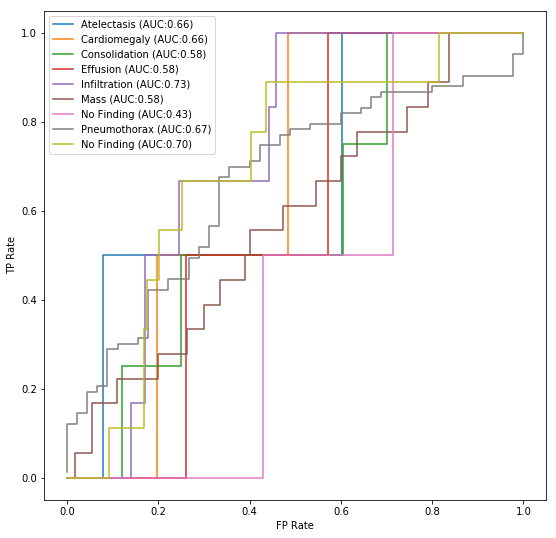

In [68]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(path_list):
    fpr, tpr, thresholds = roc_curve(t_y[:,idx].astype(int), pred_Y_1[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('FP Rate')
c_ax.set_ylabel('TP Rate')
fig.savefig('roc_1.png')

In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(9)
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [73]:
y_test_non_category = [ np.argmax(t) for t in t_y ]
y_predict_non_category = [ np.argmax(t) for t in pred_Y_1 ]

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)

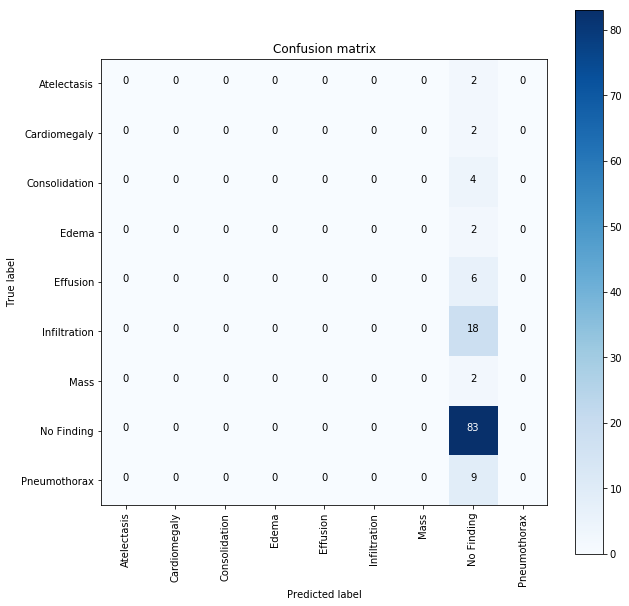

In [91]:
# confusion_mtx = confusion_matrix(t_y, pred_Y_1)
plot_confusion_matrix(conf_mat, classes = list(train_generator.class_indices.keys()), normalize=False)
plt.show()

### Unfreeze the resnet layers for training

In [75]:
# define the parameters in the same way as above, set which layers we will now unlock and how many epochs to train with the new settings
num_epochs = 5

split_at = 50

for layer in model.layers[:split_at]: layer.trainable = False
for layer in model.layers[split_at:]: layer.trainable = True

from keras.optimizers import RMSprop

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=1e-6)    

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'mae'])

In [76]:
%%time
# fit the model with the new parameters and continue training
history_2 = model.fit_generator( train_generator,
                                epochs=num_epochs,
#                               classweight=class_weights,
                                steps_per_epoch=(train_size // batch_size) + 1,
                                validation_data=validation_generator,
                                validation_steps=(validation_size // batch_size) + 1,
                                callbacks=[checkpoint, tensorboard])

Epoch 1/5
557/558 [============================>.] - ETA: 3s - loss: 0.2140 - acc: 0.9203 - mean_absolute_error: 0.1309
Epoch 00001: saving model to /models
558/558 [==============================] - 2554s 5s/step - loss: 0.2140 - acc: 0.9203 - mean_absolute_error: 0.1309 - val_loss: 0.2996 - val_acc: 0.9113 - val_mean_absolute_error: 0.0985
Epoch 2/5
557/558 [============================>.] - ETA: 3s - loss: 0.2139 - acc: 0.9204 - mean_absolute_error: 0.1309
Epoch 00002: saving model to /models
558/558 [==============================] - 2496s 4s/step - loss: 0.2139 - acc: 0.9203 - mean_absolute_error: 0.1309 - val_loss: 0.2999 - val_acc: 0.9117 - val_mean_absolute_error: 0.0985
Epoch 3/5
557/558 [============================>.] - ETA: 3s - loss: 0.2142 - acc: 0.9205 - mean_absolute_error: 0.1310
Epoch 00003: saving model to /models
558/558 [==============================] - 2162s 4s/step - loss: 0.2141 - acc: 0.9205 - mean_absolute_error: 0.1309 - val_loss: 0.2987 - val_acc: 0.9115 - 

dict_keys(['val_loss', 'val_acc', 'val_mean_absolute_error', 'loss', 'acc', 'mean_absolute_error'])


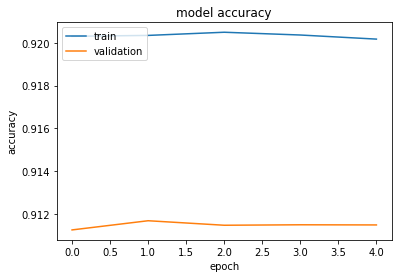

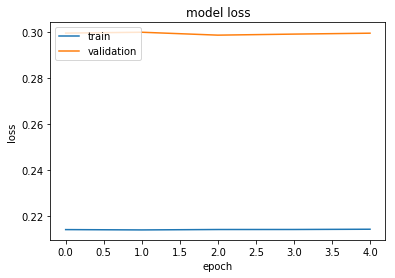

In [77]:
# trace the model performance with the new settings
print(history_2.history.keys())  

# summarize history for accuracy
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [78]:
# save the final model weights 
model.save_weights('first_trans_2.h5')  # always save your weights after training or during training

### Prediction and evaluation

In [79]:
%%time
model.evaluate_generator(test_generator, steps=(test_size // batch_size), max_queue_size=10, workers=2, use_multiprocessing=True)


[0.2989476061418277, 0.9119251841256598, 0.09723298777552213]

In [80]:
# make predictions on the testing data
y_pred = model.predict_generator(test_generator, steps=(test_size // batch_size), max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)


119/119 [==============================] - 262s 2s/step


In [81]:
y_pred[0]

array([5.0568208e-03, 2.6312692e-04, 3.8797013e-04, 6.0622874e-06,
       1.6569952e-03, 5.5141803e-02, 1.8886288e-03, 8.9359522e-01,
       7.9982296e-05], dtype=float32)

In [82]:
pred_Y_2 = model.predict(t_x, batch_size = 32, verbose = True)

128/128 [==============================] - 0s 3ms/step


In [83]:
model.load_weights('first_trans_2.h5')

In [84]:
pred_Y_2 = model.predict(t_x, batch_size = 32, verbose = True)

128/128 [==============================] - 0s 2ms/step


In [85]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(path_list, 
                                     100*np.mean(pred_Y_2,0), 
                                     100*np.mean(t_y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 1.56%, PDx: 2.48%
Cardiomegaly: Dx: 1.56%, PDx: 0.06%
Consolidation: Dx: 3.12%, PDx: 0.23%
Effusion: Dx: 1.56%, PDx: 0.03%
Infiltration: Dx: 4.69%, PDx: 1.29%
Mass: Dx: 14.06%, PDx: 6.23%
No Finding: Dx: 1.56%, PDx: 0.17%
Pneumothorax: Dx: 64.84%, PDx: 77.73%
No Finding: Dx: 7.03%, PDx: 0.04%


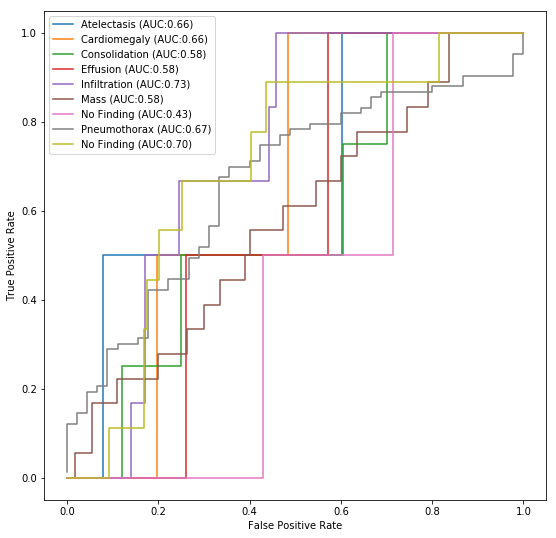

In [86]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(path_list):
    fpr, tpr, thresholds = roc_curve(t_y[:,idx].astype(int), pred_Y_2[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

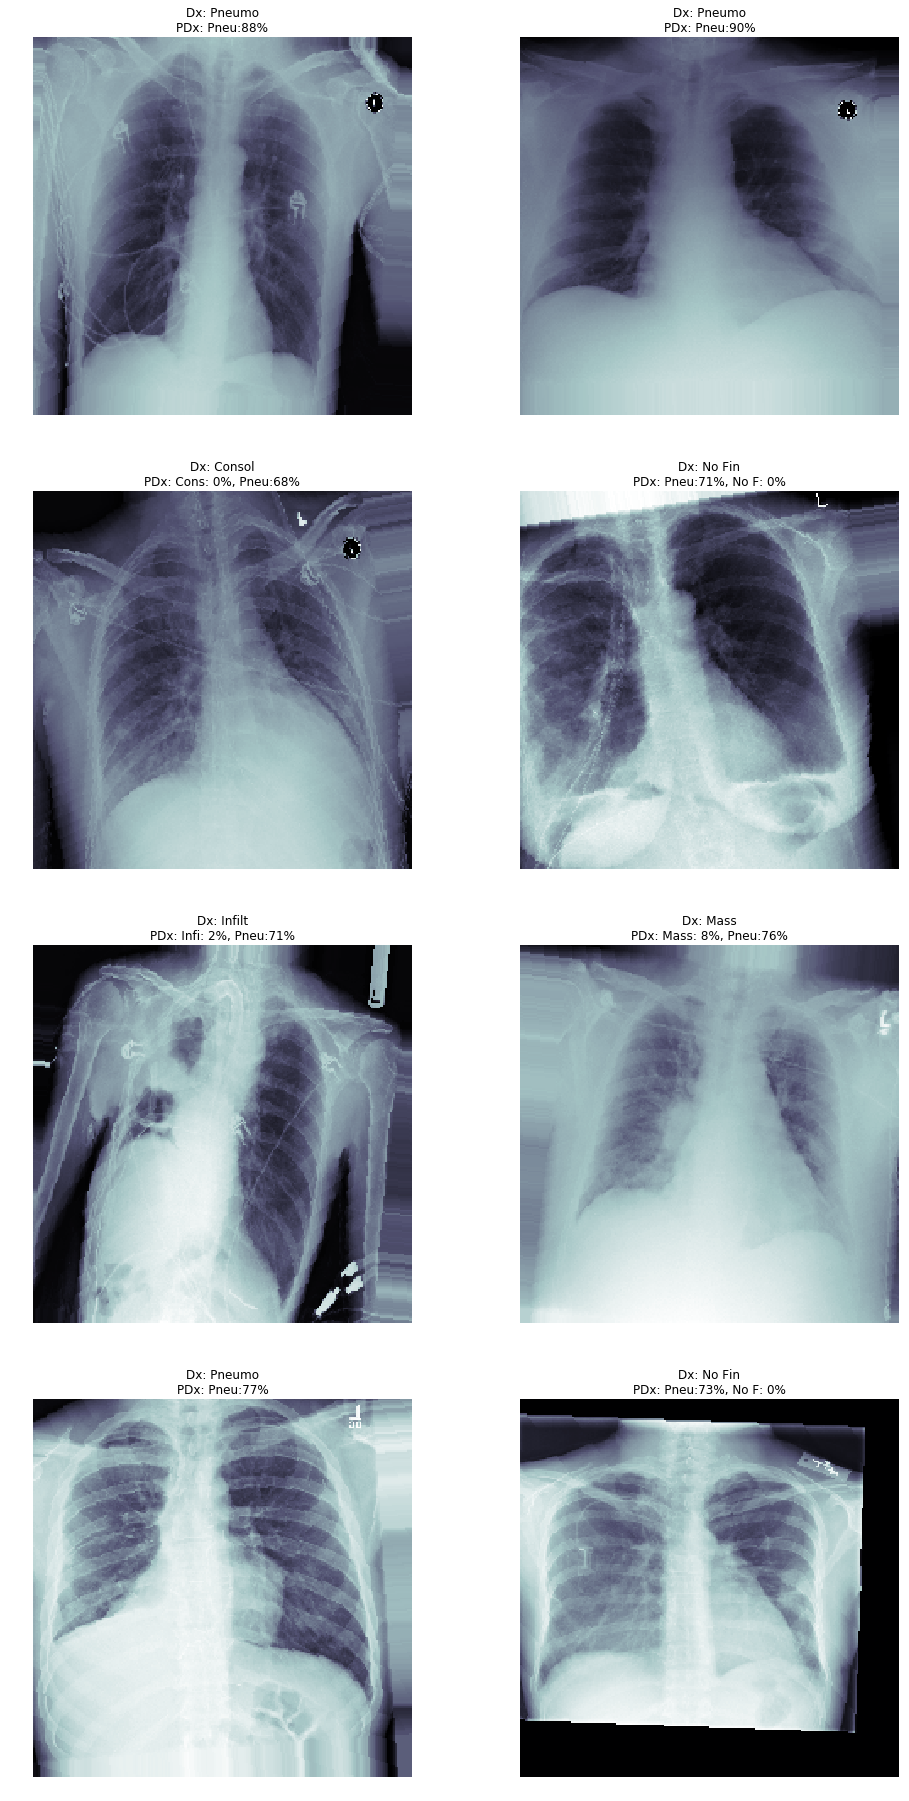

In [87]:
sickest_idx = np.argsort(np.sum(t_y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(t_x[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(path_list, t_y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(path_list, 
                                                                  t_y[idx], pred_Y_2[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

In [88]:
y_test_non_category_2 = [ np.argmax(t) for t in t_y ]
y_predict_non_category_2 = [ np.argmax(t) for t in pred_Y_1 ]

from sklearn.metrics import confusion_matrix
conf_mat_2 = confusion_matrix(y_test_non_category_2, y_predict_non_category_2)

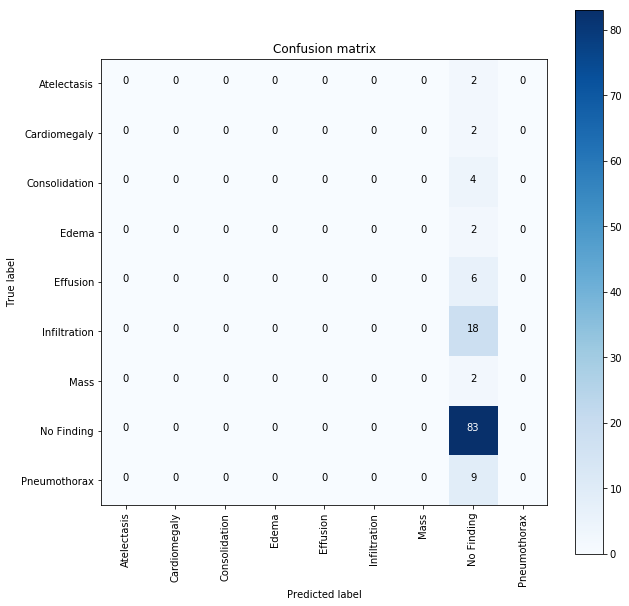

In [90]:
# confusion_mtx = confusion_matrix(t_y, pred_Y_1)
plot_confusion_matrix(conf_mat_2, classes = list(train_generator.class_indices.keys()), normalize=False)
plt.show()

In [ ]:
!rm -rf sets
!rm -rf samples
!rm -rf test
!rm -rf train
!rm -rf validation